In [1]:
dir_data = '../data'
dir_ckpt = '../ckpt/1667814523'
path_ckpt = f'{dir_ckpt}/last_ckpt.bin'

seed = 0
ids = range(0, 21)
features = [
    'temperature', 'humidity', 'dew_point', 'wind_dir', 'wind_spd',
    'uv_idx', 'visibility', 'ceiling', 'cloudiness', 'precip_prob',
    'precip_1h', 'forecast', 'capacity', 'hour', 'year', 'month', 'day'
]
hidden_dim = 10


In [2]:
import sys
sys.path.append('../')

from suncapturer.utils import seed_all

from suncapturer.losses import CompetitionMetric
from suncapturer.networks import WaveNet
from suncapturer.datasets import SolarDataset

import os
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler, minmax_scale


In [3]:
seed_all(seed)

In [4]:
df = pd.read_csv(os.path.join(dir_data, 'forecasts1_16.csv'))
df = df.fillna(0)
df['fcst_time'] = df['fcst_time'].str.split(' ').str[0]
df['fcst_time'] = pd.to_datetime(df['fcst_time'])

start = datetime.strptime('2020-09-30', '%Y-%m-%d')
df['fcst_time'] = (df['fcst_time'] - start).dt.days

valid_start = df['fcst_time'].max() - 14
train_df = df[(df['id'].isin(ids)) & (df['fcst_time'] < valid_start)].copy()
valid_df = df[(df['id'].isin(ids)) & (df['fcst_time'] >= valid_start)].copy()
test_df  = df[(df['id'] == 0) & (df['fcst_time'] >= valid_start) ].copy()

target_columns = df.columns.difference(['id', 'fcst_time', 'time', 'amount', 'relative_amount'])
for col in target_columns:
    scaler = MinMaxScaler()
    scaler.fit(train_df[col].values.reshape(-1, 1))
    
    train_df[col] = scaler.transform(train_df[col].values.reshape(-1, 1))
    valid_df[col] = scaler.transform(valid_df[col].values.reshape(-1, 1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1, 1))

train_dataset = SolarDataset(train_df, features)
valid_dataset = SolarDataset(valid_df, features)
test_dataset  = SolarDataset(test_df,   features)

In [5]:
model = WaveNet(len(features), hidden_dim)
ckpt = torch.load(path_ckpt)
model.load_state_dict(ckpt['model_state_dict'])

metric = CompetitionMetric()

In [6]:
@torch.no_grad()
def evaluate(model, dataset, k=0.0):
    score = []
    model.eval()
    for X, y in dataset:
        X, y = map(lambda x: x.unsqueeze(0), [X, y])
        out = model(X)

        bound = torch.zeros_like(out)
        bound[:, :, 0] = out[:, :, 0] - k * out[:, :, 1]
        bound[:, :, 1] = out[:, :, 0] + k * out[:, :, 1]
        bound = torch.nn.functional.relu(bound)

        loss = list(metric(bound, y).values())
        loss = list(map(lambda x: x.numpy(), loss))
        score.append(loss)
        
    return np.mean(score, axis=0)

In [7]:
evaluate(model, test_dataset)

/home/dongjin/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


array([0.3772503, 0.6859098, 0.       , 2.8079908], dtype=float32)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


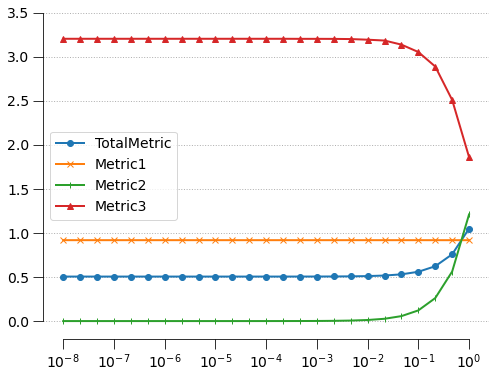

In [10]:
scores = []
ks = np.linspace(0.0, 1.0, num=101)
ks = np.logspace(-8.0,  0.0, num=25)
for k in ks:
    score = evaluate(model, valid_dataset, k)
    scores.append(score)
    
scores = np.stack(scores)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log10(ks), scores[:, 0], 'o-', linewidth=2, label='TotalMetric')
ax.plot(np.log10(ks), scores[:, 1], 'x-', linewidth=2, label='Metric1')
ax.plot(np.log10(ks), scores[:, 2], '|-', linewidth=2, label='Metric2')
ax.plot(np.log10(ks), scores[:, 3], '^-', linewidth=2, label='Metric3')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0, 3.5)
ax.spines['bottom'].set_bounds(-8, 0)
ax.tick_params(length=10)

plt.ylim(-0.2, 3.5)
plt.xticks(ticks=np.log10(ks)[::3], labels=[f'$10^{{{int(x)}}}$' for x in np.log10(ks)[::3]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.legend()
plt.show()

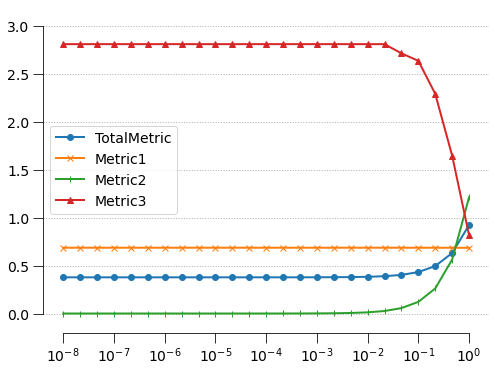

In [22]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 14

scores = []
ks = np.linspace(0.0, 1.0, num=101)
ks = np.logspace(-8.0,  0.0, num=25)
for k in ks:
    score = evaluate(model, test_dataset, k)
    scores.append(score)
    
scores = np.stack(scores)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log10(ks), scores[:, 0], 'o-', linewidth=2, label='TotalMetric')
ax.plot(np.log10(ks), scores[:, 1], 'x-', linewidth=2, label='Metric1')
ax.plot(np.log10(ks), scores[:, 2], '|-', linewidth=2, label='Metric2')
ax.plot(np.log10(ks), scores[:, 3], '^-', linewidth=2, label='Metric3')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0, 3.0)
ax.spines['bottom'].set_bounds(-8, 0)
ax.tick_params(length=10)

plt.ylim(-0.2, 3.2)
plt.xticks(ticks=np.log10(ks)[::3], labels=[f'$10^{{{int(x)}}}$' for x in np.log10(ks)[::3]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.legend()
plt.show()

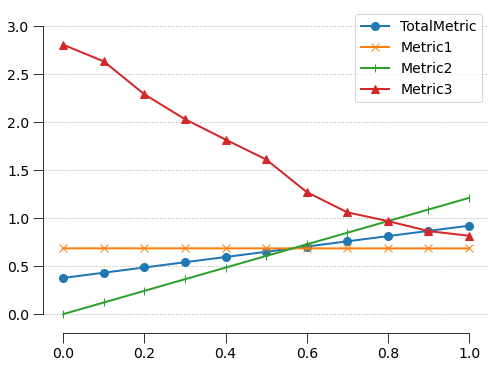

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 14

scores = []
ks = np.linspace(0.0, 1.0, num=11)
for k in ks:
    score = evaluate(model, test_dataset, k)
    scores.append(score)
    
scores = np.stack(scores)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ks, scores[:, 0], 'o-', linewidth=2, markersize=8, label='TotalMetric')
ax.plot(ks, scores[:, 1], 'x-', linewidth=2, markersize=8, label='Metric1')
ax.plot(ks, scores[:, 2], '|-', linewidth=2, markersize=8, label='Metric2')
ax.plot(ks, scores[:, 3], '^-', linewidth=2, markersize=8, label='Metric3')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0, 3.0)
ax.spines['bottom'].set_bounds(0, 1.0)
ax.tick_params(length=10)

plt.ylim(-0.2, 3.2)
# plt.xticks(ticks=np.log10(ks)[::3], labels=[f'$10^{{{int(x)}}}$' for x in np.log10(ks)[::3]])
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.legend()
plt.show()